<a href="https://colab.research.google.com/github/AbdullahMakhdoom/Employee_Retention_Prediction/blob/main/Model_Selection%26Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# download the dataset .csv from github 
!curl -LJO https://raw.githubusercontent.com/CODESTUDIO-GIT/endtoend-ml-projects/master/hr_employee_churn_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  517k  100  517k    0     0   894k      0 --:--:-- --:--:-- --:--:--  893k


In [3]:
# create dataframe to load dataset
df = pd.read_csv("hr_employee_churn_data.csv")

In [4]:
df.head()

,empid,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left
0,1,0.38,0.53,2,157,3,0,0,low,1
1,2,0.80,0.86,5,262,6,0,0,medium,1
2,3,0.11,0.88,7,272,4,0,0,medium,1
3,4,0.72,0.87,5,223,5,0,0,low,1
4,5,0.37,0.52,2,159,3,0,0,low,1


In [5]:
# spelling correction 
df.rename(columns = {'average_montly_hours' : 'average_monthly_hours'}, inplace=True)

In [6]:
# checking the column names and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   empid                  14999 non-null  int64  
 1   satisfaction_level     14997 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_monthly_hours  14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 1.1+ MB


In [7]:
# dropping emid column
df.drop(['empid'], axis=1, inplace=True)

### Handling missing values

In [8]:
# handling missing values
df.isnull().sum()

satisfaction_level       2
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
salary                   0
left                     0
dtype: int64

In [9]:
df['satisfaction_level'].describe()

count    14997.000000
mean         0.612863
std          0.248634
min          0.090000
25%          0.440000
50%          0.640000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

In [10]:
# Filling the missing values with mean 
df['satisfaction_level'].fillna(df['satisfaction_level'].mean(), inplace=True)

In [11]:
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
salary                   0
left                     0
dtype: int64

Handling Categorical Features

In [12]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [13]:
salary_dummies = pd.get_dummies(df['salary'], drop_first=True)
salary_dummies

,low,medium
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
14994,1,0
14995,1,0
14996,1,0
14997,1,0


In [14]:
df = pd.concat([df,salary_dummies], axis=1)

In [15]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left,low,medium
0,0.38,0.53,2,157,3,0,0,low,1,1,0
1,0.80,0.86,5,262,6,0,0,medium,1,0,1
2,0.11,0.88,7,272,4,0,0,medium,1,0,1
3,0.72,0.87,5,223,5,0,0,low,1,1,0
4,0.37,0.52,2,159,3,0,0,low,1,1,0


In [16]:
df.drop(['salary'], axis=1, inplace=True)

In [17]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left,low,medium
0,0.38,0.53,2,157,3,0,0,1,1,0
1,0.80,0.86,5,262,6,0,0,1,0,1
2,0.11,0.88,7,272,4,0,0,1,0,1
3,0.72,0.87,5,223,5,0,0,1,1,0
4,0.37,0.52,2,159,3,0,0,1,1,0


## Split Dataset into Training and Test set

In [18]:
X = df.drop(labels='left', axis=1)
y = df['left']


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
len(X_train)

11999

In [21]:
len(X_test)

3000

### Model Selection

Training and comparing results from two classifiers : Random Forest Classifier and XGBoost Classifier.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [23]:
# Dictionary  for storing model names and parameters 
# which are to be inputed in GridSeaerchCV
# for finding best performing model's hyperparameters
model_dictionary = {
    'RandomForestClassifier':{
        'model' : RandomForestClassifier(),
        'param' :{
            'n_estimators' : [10,50,100,130],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : range(2, 4, 1),
            'max_features' : ['auto', 'log2']
        }
    },
    'XGBClassifier':{
        'model' : XGBClassifier(objective='binary:logistic'),
        'param' : {
            'learning_rate' : [0.5, 0.1, 0.01, 0.001],
            'max_depth' : [3, 5, 10, 20],
            'n_estimators': [10, 50 ,100, 200]
        }
    }
}

In [24]:
scores = []
for model_name, model_param in model_dictionary.items():
  model_selection = GridSearchCV(estimator=model_param['model'], 
                                 param_grid=model_param['param'],
                                 cv=5,
                                 return_train_score=False)
  model_selection.fit(X,y)
  scores.append({
      'model' : model_name,
      'best_score': model_selection.best_score_,
      'best_params': model_selection.best_params_
  })

In [25]:
scores

[{'best_params': {'criterion': 'entropy',
   'max_depth': 3,
   'max_features': 'auto',
   'n_estimators': 10},
  'best_score': 0.9226634211403801,
  'model': 'RandomForestClassifier'},
 {'best_params': {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200},
  'best_score': 0.9902661776147605,
  'model': 'XGBClassifier'}]

## Model Building

In [31]:
model_xgb = XGBClassifier(objective = 'binary:logistic', 
                          learning_rate=0.1,
                          max_depth=20,
                          n_estimators = 200)

In [32]:
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [33]:
model_xgb.score(X_test, y_test)

0.9923333333333333

In [35]:
X_test[:1]

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,low,medium
1670,0.44,0.57,2,141,3,0,0,0,1


In [37]:
y_test[:1]

1670    1
Name: left, dtype: int64

In [36]:
model_xgb.predict(X_test[:1])

array([1])

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_xgb.predict(X_test))
cm

array([[2292,    7],
       [  16,  685]])

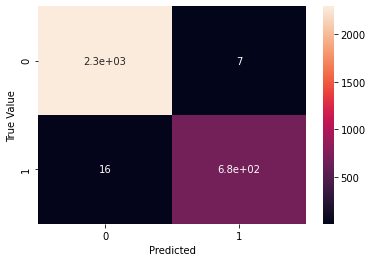

In [42]:
# plotting the confusion matric in graph
sns.heatmap(cm, annot= True)
plt.xlabel('Predicted')
plt.ylabel('True Value')
plt.show()